CIFAR10 - DenseNet solution. Adaptación de https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/applications/densenet.py

Install Keras just in case...

In [1]:
!pip3 install keras
!pip3 install keras_applications

     |████████████████████████████████| 51kB 4.4MB/s 


Imports...

In [2]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import warnings

from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Flatten, Input, Conv2D, Add, ZeroPadding2D, Dense, Dropout, Activation, Reshape, Conv2DTranspose, UpSampling2D, MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import add
from keras import Model
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.regularizers import l2
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.applications.imagenet_utils import preprocess_input as _preprocess_input
import keras.backend as K
from keras.engine.topology import get_source_inputs
from keras import utils

import numpy as np

from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

from keras.datasets import cifar10

import keras

Define batch size, number of epochs and number of classes


In [3]:
batch_size = 32
num_classes = 10
epochs = 75

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)

y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

170508288/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [5]:
## Data Augmentation with an ImageGenerator
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.3,
    rotation_range=45,
    vertical_flip=False)

Movidas

In [6]:
def __conv_block(ip, nb_filter, bottleneck=False, dropout_rate=None,
                 weight_decay=1e-4, block_prefix=None):
    '''
    Adds a convolution layer (with batch normalization and relu),
    and optionally a bottleneck layer.
    # Arguments
        ip: Input tensor
        nb_filter: integer, the dimensionality of the output space
            (i.e. the number output of filters in the convolution)
        bottleneck: if True, adds a bottleneck convolution block
        dropout_rate: dropout rate
        weight_decay: weight decay factor
        block_prefix: str, for unique layer naming
     # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if data_format='channels_first'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if data_format='channels_last'.
    # Output shape
        4D tensor with shape:
        `(samples, filters, new_rows, new_cols)` if data_format='channels_first'
        or 4D tensor with shape:
        `(samples, new_rows, new_cols, filters)` if data_format='channels_last'.
        `rows` and `cols` values might have changed due to stride.
    # Returns
        output tensor of block
    '''
    with K.name_scope('ConvBlock'):
        concat_axis = 1 if K.image_data_format() == 'channels_first' else -1

        x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5,
                               name=name_or_none(block_prefix, '_bn'))(ip)
        x = Activation('relu')(x)

        if bottleneck:
            inter_channel = nb_filter * 4

            x = Conv2D(inter_channel, (1, 1), kernel_initializer='he_normal',
                       padding='same', use_bias=False,
                       kernel_regularizer=l2(weight_decay),
                       name=name_or_none(block_prefix, '_bottleneck_conv2D'))(x)
            x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5,
                                   name=name_or_none(block_prefix, '_bottleneck_bn'))(x)
            x = Activation('relu')(x)

        x = Conv2D(nb_filter, (3, 3), kernel_initializer='he_normal', padding='same',
                   use_bias=False, name=name_or_none(block_prefix, '_conv2D'))(x)
        if dropout_rate:
            x = Dropout(dropout_rate)(x)

    return x

In [7]:
def __dense_block(x, nb_layers, nb_filter, growth_rate, bottleneck=False,
                  dropout_rate=None, weight_decay=1e-4, grow_nb_filters=True,
                  return_concat_list=False, block_prefix=None):
    '''
    Build a dense_block where the output of each conv_block is fed
    to subsequent ones
    # Arguments
        x: input keras tensor
        nb_layers: the number of conv_blocks to append to the model
        nb_filter: integer, the dimensionality of the output space
            (i.e. the number output of filters in the convolution)
        growth_rate: growth rate of the dense block
        bottleneck: if True, adds a bottleneck convolution block to
            each conv_block
        dropout_rate: dropout rate
        weight_decay: weight decay factor
        grow_nb_filters: if True, allows number of filters to grow
        return_concat_list: set to True to return the list of
            feature maps along with the actual output
        block_prefix: str, for block unique naming
    # Return
        If return_concat_list is True, returns a list of the output
        keras tensor, the number of filters and a list of all the
        dense blocks added to the keras tensor
        If return_concat_list is False, returns a list of the output
        keras tensor and the number of filters
    '''
    with K.name_scope('DenseBlock'):
        concat_axis = 1 if K.image_data_format() == 'channels_first' else -1

        x_list = [x]

        for i in range(nb_layers):
            cb = __conv_block(x, growth_rate, bottleneck, dropout_rate, weight_decay,
                              block_prefix=name_or_none(block_prefix, '_%i' % i))
            x_list.append(cb)

            x = concatenate([x, cb], axis=concat_axis)

            if grow_nb_filters:
                nb_filter += growth_rate

        if return_concat_list:
            return x, nb_filter, x_list
        else:
            return x, nb_filter

In [8]:
def __transition_block(ip, nb_filter, compression=1.0, weight_decay=1e-4,
                       block_prefix=None, transition_pooling='max'):
    '''
    Adds a pointwise convolution layer (with batch normalization and relu),
    and an average pooling layer. The number of output convolution filters
    can be reduced by appropriately reducing the compression parameter.
    # Arguments
        ip: input keras tensor
        nb_filter: integer, the dimensionality of the output space
            (i.e. the number output of filters in the convolution)
        compression: calculated as 1 - reduction. Reduces the number
            of feature maps in the transition block.
        weight_decay: weight decay factor
        block_prefix: str, for block unique naming
    # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if data_format='channels_first'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if data_format='channels_last'.
    # Output shape
        4D tensor with shape:
        `(samples, nb_filter * compression, rows / 2, cols / 2)`
        if data_format='channels_first'
        or 4D tensor with shape:
        `(samples, rows / 2, cols / 2, nb_filter * compression)`
        if data_format='channels_last'.
    # Returns
        a keras tensor
    '''
    with K.name_scope('Transition'):
        concat_axis = 1 if K.image_data_format() == 'channels_first' else -1

        x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5,
                               name=name_or_none(block_prefix, '_bn'))(ip)
        x = Activation('relu')(x)
        x = Conv2D(int(nb_filter * compression), (1, 1), kernel_initializer='he_normal',
                   padding='same', use_bias=False, kernel_regularizer=l2(weight_decay),
                   name=name_or_none(block_prefix, '_conv2D'))(x)
        if transition_pooling == 'avg':
            x = AveragePooling2D((2, 2), strides=(2, 2))(x)
        elif transition_pooling == 'max':
            x = MaxPooling2D((2, 2), strides=(2, 2))(x)

        return x

In [9]:
def __transition_up_block(ip, nb_filters, type='deconv', weight_decay=1E-4,
                          block_prefix=None):
    '''Adds an upsampling block. Upsampling operation relies on the the type parameter.
    # Arguments
        ip: input keras tensor
        nb_filters: integer, the dimensionality of the output space
            (i.e. the number output of filters in the convolution)
        type: can be 'upsampling', 'subpixel', 'deconv'. Determines
            type of upsampling performed
        weight_decay: weight decay factor
        block_prefix: str, for block unique naming
    # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if data_format='channels_first'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if data_format='channels_last'.
    # Output shape
        4D tensor with shape:
        `(samples, nb_filter, rows * 2, cols * 2)` if data_format='channels_first'
        or 4D tensor with shape:
        `(samples, rows * 2, cols * 2, nb_filter)` if data_format='channels_last'.
    # Returns
        a keras tensor
    '''
    with K.name_scope('TransitionUp'):

        if type == 'upsampling':
            x = UpSampling2D(name=name_or_none(block_prefix, '_upsampling'))(ip)
        elif type == 'subpixel':
            x = Conv2D(nb_filters, (3, 3), activation='relu', padding='same',
                       kernel_regularizer=l2(weight_decay), use_bias=False,
                       kernel_initializer='he_normal',
                       name=name_or_none(block_prefix, '_conv2D'))(ip)
            x = SubPixelUpscaling(scale_factor=2,
                                  name=name_or_none(block_prefix, '_subpixel'))(x)
            x = Conv2D(nb_filters, (3, 3), activation='relu', padding='same',
                       kernel_regularizer=l2(weight_decay), use_bias=False,
                       kernel_initializer='he_normal',
                       name=name_or_none(block_prefix, '_conv2D'))(x)
        else:
            x = Conv2DTranspose(nb_filters, (3, 3), activation='relu', padding='same',
                                strides=(2, 2), kernel_initializer='he_normal',
                                kernel_regularizer=l2(weight_decay),
                                name=name_or_none(block_prefix, '_conv2DT'))(ip)
        return x

In [10]:
def __create_dense_net(nb_classes, img_input, include_top, depth=40, nb_dense_block=3,
                       growth_rate=12, nb_filter=-1, nb_layers_per_block=-1,
                       bottleneck=False, reduction=0.0, dropout_rate=None,
                       weight_decay=1e-4, subsample_initial_block=False, pooling=None,
                       activation='softmax', transition_pooling='avg'):
    ''' Build the DenseNet model
    # Arguments
        nb_classes: number of classes
        img_input: tuple of shape (channels, rows, columns) or (rows, columns, channels)
        include_top: flag to include the final Dense layer
        depth: number or layers
        nb_dense_block: number of dense blocks to add to end (generally = 3)
        growth_rate: number of filters to add per dense block
        nb_filter: initial number of filters. Default -1 indicates initial number
            of filters is 2 * growth_rate
        nb_layers_per_block: number of layers in each dense block.
                Can be a -1, positive integer or a list.
                If -1, calculates nb_layer_per_block from the depth of the network.
                If positive integer, a set number of layers per dense block.
                If list, nb_layer is used as provided. Note that list size must
                be (nb_dense_block + 1)
        bottleneck: add bottleneck blocks
        reduction: reduction factor of transition blocks. Note : reduction value is
            inverted to compute compression
        dropout_rate: dropout rate
        weight_decay: weight decay rate
        subsample_initial_block: Changes model type to suit different datasets.
            Should be set to True for ImageNet, and False for CIFAR datasets.
            When set to True, the initial convolution will be strided and
            adds a MaxPooling2D before the initial dense block.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model
                will be the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a
                2D tensor.
            - `max` means that global max pooling will
                be applied.
        activation: Type of activation at the top layer. Can be one of 'softmax' or
            'sigmoid'. Note that if sigmoid is used, classes must be 1.
        transition_pooling: `avg` for avg pooling (default), `max` for max pooling,
            None for no pooling during scale transition blocks. Please note that this
            default differs from the DenseNetFCN paper in accordance with the DenseNet
            paper.
    # Returns
        a keras tensor
    # Raises
        ValueError: in case of invalid argument for `reduction`
            or `nb_dense_block`
    '''
    with K.name_scope('DenseNet'):
        concat_axis = 1 if K.image_data_format() == 'channels_first' else -1

        if reduction != 0.0:
            if not (reduction <= 1.0 and reduction > 0.0):
                raise ValueError('`reduction` value must lie between 0.0 and 1.0')

        # layers in each dense block
        if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
            nb_layers = list(nb_layers_per_block)  # Convert tuple to list

            if len(nb_layers) != nb_dense_block:
                raise ValueError('If `nb_dense_block` is a list, its length must match '
                                 'the number of layers provided by `nb_layers`.')

            final_nb_layer = nb_layers[-1]
            nb_layers = nb_layers[:-1]
        else:
            if nb_layers_per_block == -1:
                assert (depth - 4) % 3 == 0, ('Depth must be 3 N + 4 '
                                              'if nb_layers_per_block == -1')
                count = int((depth - 4) / 3)

                if bottleneck:
                    count = count // 2

                nb_layers = [count for _ in range(nb_dense_block)]
                final_nb_layer = count
            else:
                final_nb_layer = nb_layers_per_block
                nb_layers = [nb_layers_per_block] * nb_dense_block

        # compute initial nb_filter if -1, else accept users initial nb_filter
        if nb_filter <= 0:
            nb_filter = 2 * growth_rate

        # compute compression factor
        compression = 1.0 - reduction

        # Initial convolution
        if subsample_initial_block:
            initial_kernel = (7, 7)
            initial_strides = (2, 2)
        else:
            initial_kernel = (3, 3)
            initial_strides = (1, 1)

        x = Conv2D(nb_filter, initial_kernel, kernel_initializer='he_normal',
                   padding='same', name='initial_conv2D', strides=initial_strides,
                   use_bias=False, kernel_regularizer=l2(weight_decay))(img_input)

        if subsample_initial_block:
            x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5,
                                   name='initial_bn')(x)
            x = Activation('relu')(x)
            x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

        # Add dense blocks
        for block_idx in range(nb_dense_block - 1):
            x, nb_filter = __dense_block(x, nb_layers[block_idx], nb_filter,
                                         growth_rate, bottleneck=bottleneck,
                                         dropout_rate=dropout_rate,
                                         weight_decay=weight_decay,
                                         block_prefix='dense_%i' % block_idx)
            # add transition_block
            x = __transition_block(x, nb_filter, compression=compression,
                                   weight_decay=weight_decay,
                                   block_prefix='tr_%i' % block_idx,
                                   transition_pooling=transition_pooling)
            nb_filter = int(nb_filter * compression)

        # The last dense_block does not have a transition_block
        x, nb_filter = __dense_block(x, final_nb_layer, nb_filter, growth_rate,
                                     bottleneck=bottleneck, dropout_rate=dropout_rate,
                                     weight_decay=weight_decay,
                                     block_prefix='dense_%i' % (nb_dense_block - 1))

        x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5, name='final_bn')(x)
        x = Activation('relu')(x)

        if include_top:
            if pooling == 'avg':
                x = GlobalAveragePooling2D()(x)
            elif pooling == 'max':
                x = GlobalMaxPooling2D()(x)
            x = Dense(nb_classes, activation=activation)(x)
        else:
            if pooling == 'avg':
                x = GlobalAveragePooling2D()(x)
            elif pooling == 'max':
                x = GlobalMaxPooling2D()(x)

        return x

In [11]:
def name_or_none(prefix, name):
    return prefix + name if (prefix is not None and name is not None) else None

In [12]:
input_shape = x_train.shape[1:]
input_shape = _obtain_input_shape(input_shape,
                                  default_size=224,
                                  min_size=32,
                                  data_format=K.image_data_format(),
                                  require_flatten=True,
                                  weights=None)
img_input = Input(shape=input_shape)
x = __create_dense_net(num_classes, img_input, True)

x = Flatten()(x)
x = Dense(num_classes)(x)
x = Activation('softmax')(x)

model = Model(get_source_inputs(img_input), x, name='densenet')

model.summary()

Model: "densenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
initial_conv2D (Conv2D)         (None, 32, 32, 24)   648         input_1[0][0]                    
__________________________________________________________________________________________________
dense_0_0_bn (BatchNormalizatio (None, 32, 32, 24)   96          initial_conv2D[0][0]             
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 24)   0           dense_0_0_bn[0][0]               
___________________________________________________________________________________________

Define an optimizer 

In [13]:
opt = SGD(lr=0.1, decay=1e-6)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


DEFINE A LEARNING RATE SCHEDULER

In [14]:
def scheduler(epoch):
    if epoch < 25:
        return .1
    elif epoch < 50:
        return 0.01
    else:
        return 0.001

# Callbacks
set_lr = LRS(scheduler)
es = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

Compile the model, define loss and link the optimizer

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

Finally, train the model and evaluate over the test data

In [16]:
history=model.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                  steps_per_epoch=len(x_train) / batch_size, 
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  callbacks=[set_lr, es],
                  verbose=1)

# Evaluate over test
score = model.evaluate(x_test, y_test, verbose=0)


print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/75
1562/1562 [==============================] - 167s 71ms/step - loss: 1.8981 - accuracy: 0.3392 - val_loss: 1.5948 - val_accuracy: 0.4569
Epoch 2/75
1562/1562 [==============================] - 106s 68ms/step - loss: 1.5878 - accuracy: 0.4621 - val_loss: 1.5791 - val_accuracy: 0.4856
Epoch 3/75
1562/1562 [==============================] - 106s 68ms/step - loss: 1.4102 - accuracy: 0.5267 - val_loss: 1.2625 - val_accuracy: 0.5845
Epoch 4/75
1562/1562 [==============================] - 107s 68ms/step - loss: 1.2857 - accuracy: 0.5740 - val_loss: 1.3136 - val_accuracy: 0.5731
Epoch 5/75
1562/1562 [==============================] - 107s 68ms/step - loss: 1.1916 - accuracy: 0.6079 - val_loss: 1.1148 - val_accuracy: 0.6391
Epoch 6/75
1562/1562 [==============================] - 112s 72ms/step - loss: 1.1190 - accuracy: 0.6362 - val_loss: 1.0134 - val_accuracy: 0.6828
Epoch 7/75
1562/1562 [==============================] - 106s 68ms/step - loss: 1.0606 - accuracy: 0.6588 - val_loss: 1

In [17]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [18]:
import matplotlib.pyplot as plt

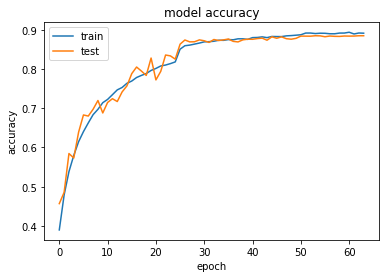

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()